<a href="https://colab.research.google.com/github/dev-SR/Deep-Learning/blob/main/03-cnn-basic/cnn-basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Basic with pytorch

In [1]:
"""
cd .\03-cnn-basic\
jupyter nbconvert --to markdown cnn-basic.ipynb --output README.md
"""

import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn.functional as Fn
import torch.nn as nn

## Load Dataset from `torchvision`

- [Torchvision](https://pytorch.org/vision/stable/datasets.html)  provides many built-in datasets in the `torchvision.datasets` module, as well as utility classes for building your own datasets.



In [2]:
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Setup training data
train_data = datasets.CIFAR10(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.CIFAR10(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [31]:
# See classes
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

The next step is to prepare it with a `torch.utils.data.DataLoader` or `DataLoader` for short.

The DataLoader does what you think it might do. It helps load data into a model. For training and for inference. It turns a large Dataset into a Python iterable of smaller chunks. These smaller chunks are called `batches` or `mini-batches` and can be set by the `batch_size` parameter. Because it's more computationally efficient. `batch_size=32` is a good place to start for a fair amount of problems. But since this is a value you can set (a hyperparameter) you can try all different kinds of values, though generally powers of 2 are used most often (e.g. 32, 64, 128, 256, 512).





<div align="center">
<img src="https://raw.githubusercontent.com/dev-SR/Deep-Learning/main/03-cnn-basic/img/batching-fashionmnist.png
" alt="batch" width="800px">
</div>


In [4]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 1563 batches of 32
Length of test dataloader: 313 batches of 32


In [5]:
dataiter = iter(train_dataloader)
images,labels  = next(dataiter)
print(images.shape) # [32, 3, 32, 32] -> [batch_size,channels,image_size(x,y)]

torch.Size([32, 3, 32, 32])


In [6]:
print(len(images)) # 32 images per batch
print(images[0].shape) # [3 channels, 32x32]
print(labels[0].item())

32
torch.Size([3, 32, 32])
0


## Visulize Data

In [11]:
img = images[0]
print(type(img))

<class 'torch.Tensor'>


In [12]:
npimg = img.numpy()
print(npimg.shape)  

(3, 32, 32)


In [13]:
npimg = np.transpose(npimg,(1,2,0))
print(npimg.shape) # [32x32,3 channels]


(32, 32, 3)


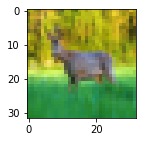

In [14]:
plt.figure(figsize=(2,2))
plt.imshow(npimg)
plt.show()

In [16]:
def imshow(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg,(1,2,0))
    plt.imshow(npimg)
    plt.show()

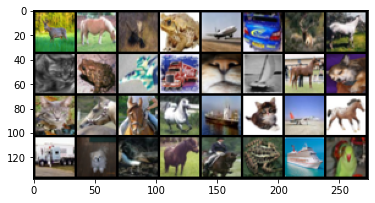

In [19]:
imshow(torchvision.utils.make_grid(images))

## Single Convolution Layer

<div align="center">
<img src="https://raw.githubusercontent.com/dev-SR/Deep-Learning/main/03-cnn-basic/img/ConvLayer.png" alt="ConvLayer.png" width="800px">
</div>

In [20]:
class FirstCNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        """ 
        in_channels: Number of channels in the input image
        out_channels: Number of channels produced by the convolution
        kernel_size: Size of the convolving kernel
        stride (int or tuple, optional): Stride of the convolution. Default: 1
        padding (int, tuple or str, optional): Padding added to all four sides of
            the input. Default: 0
        """
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5) 
        #IN: (B,InC:3,32x32) -> OUT: (B,OutC:6,[32-(5-S1)x32-(5-1)]) -> OUT: (B,6C,28x28)
    
    def forward(self,X):
        X = self.conv1(X)
        return X

In [21]:
net = FirstCNN()
out  = net(images)
out.shape

torch.Size([32, 6, 28, 28])

In [22]:
for param in net.parameters():
    print(param.shape) #total number of parameters of (f*f*InC+1)*OutC.


torch.Size([6, 3, 5, 5])
torch.Size([6])


In [23]:
out1 = out[0,0,:,:].detach().numpy() #0th image of the batch,0th chanel, all x, all y
print(out1.shape)

(28, 28)


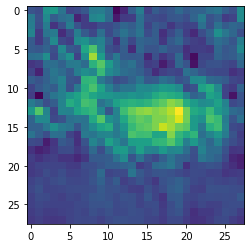

In [24]:
# ploting 
plt.imshow(out[0,0,:,:].detach().numpy())
plt.show()

## Deep Convolutional Network

In [25]:
class FirstCNN_v2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,8,3), # (B,InC:3,32x32) -> (B,OutC:8,30X30)
            nn.Conv2d(8,16,3) # (B,InC:8,30X30) -> (B,OutC:16,28x28)
        )
    
    def forward(self,X):
        X = self.model(X)
        return X

In [26]:
net = FirstCNN_v2()
out = net(images)
out.shape

torch.Size([32, 16, 28, 28])

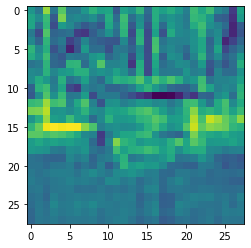

In [27]:
plt.imshow(out[0,0,:,:].detach().numpy())
plt.show()

In [28]:
class FirstCNN_v3(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,6,5), # (B,InC:3,32x32) -> (B,OutC:6,28x28)
            nn.AvgPool2d(2,stride=2), # (B,6,28x28) ->(B,6,[28/sx28/s]) -> (B,6,14x14)
            nn.Conv2d(6,16,5), # (B,6,14x14) -> (B,16,10x10)
            nn.AvgPool2d(2,stride=2) # (B,16,10x10) ->(B,16,5x5)

        )
    
    def forward(self,X):
        X = self.model(X)
        return X

In [29]:
net = FirstCNN_v3()
out = net(images)
out.shape

torch.Size([32, 16, 5, 5])

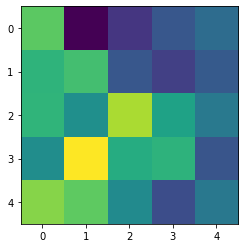

In [30]:
plt.imshow(out[0,0,:,:].detach().numpy())
plt.show()

## LeNet Architecture

<div align="center">
<img src="https://raw.githubusercontent.com/dev-SR/Deep-Learning/main/03-cnn-basic/img/ConvInOut.png" alt="ConvInOut.png" width="900px">
</div>

In [31]:
class LeNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.cnn_layer = nn.Sequential(
            nn.Conv2d(3,6,5),               # (B,3,32X32)   ->    (B,6,28X28)
            nn.Tanh(),
            nn.AvgPool2d(2,stride=2),       # (B,6,28X28)   ->    (B,6,14X14)
            nn.Conv2d(6,16,5),              # (B,6,14X14)   ->    (B,16,10X10)
            nn.Tanh(),
            nn.AvgPool2d(2,stride=2),       # (B,16,10X10)  ->    (B,16,5X5)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(400,120),             # (16X5X5) ~ (B,400) ->(B,120)
            nn.Tanh(),
            nn.Linear(120,84),              #            (B,120) ->(B,84)
            nn.Tanh(),
            nn.Linear(84,10)                #            (B,84) ->(B,10)
        )
    
    def forward(self,x):
        print(f"Input Shape:\n {x.shape}")
        x = self.cnn_layer(x)
        print(f"Conv Output Shape:\n {x.shape}")
        x = x.view(x.shape[0],-1)
        print(f"Flatten 16X5X5:\n {x.shape}")
        x = self.fc_layer(x)
        print(f"Finnal Output:\n {x.shape}")
        return x

In [32]:
net = LeNet()
out = net(images)
out.shape

Input Shape:
 torch.Size([32, 3, 32, 32])
Conv Output Shape:
 torch.Size([32, 16, 5, 5])
Flatten 16X5X5:
 torch.Size([32, 400])
Finnal Output:
 torch.Size([32, 10])


torch.Size([32, 10])

In [34]:
out.data[:5]

tensor([[ 0.0856,  0.0488,  0.0055, -0.0714,  0.0173,  0.0363, -0.0244,  0.0228,
          0.0612, -0.0432],
        [ 0.0991,  0.0505,  0.0132, -0.0533,  0.0206,  0.0412, -0.0313,  0.0236,
          0.0794, -0.0351],
        [ 0.0884,  0.0510,  0.0114, -0.0692,  0.0147,  0.0407, -0.0335,  0.0203,
          0.0694, -0.0393],
        [ 0.0985,  0.0478,  0.0211, -0.0551,  0.0162,  0.0437, -0.0223,  0.0190,
          0.0757, -0.0330],
        [ 0.1024,  0.0482,  0.0212, -0.0611,  0.0173,  0.0460, -0.0314,  0.0213,
          0.0880, -0.0226]])

In [35]:
max_vals,pred_class = torch.max(out.data,dim=1)
pred_class

tensor([0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

### Get hold of individual layer:

In [36]:
out = net.cnn_layer[0](images) # Result of first convolution
out.shape

torch.Size([32, 6, 28, 28])

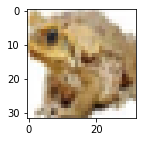

In [37]:
image_id =3
plt.figure(figsize=(2,2))
imshow(images[image_id])

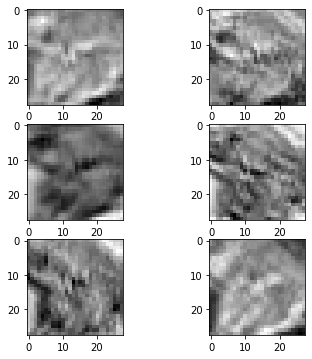

In [38]:
# ploting each channel of a resultant image after conv1
plt.figure(figsize=(6,6))
plt.subplot(321)
for i in range(6):
    ax = plt.subplot(3,2,i+1)
    ax.imshow(out[image_id,i,:,:].detach().numpy(),cmap="binary")
plt.show()

## Train LetNet

In [7]:
class LeNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.cnn_layer = nn.Sequential(
            nn.Conv2d(3,6,5),               # (B,3,32X32)   ->    (B,6,28X28)
            nn.Tanh(),
            nn.AvgPool2d(2,stride=2),       # (B,6,28X28)   ->    (B,6,14X14)
            nn.Conv2d(6,16,5),              # (B,6,14X14)   ->    (B,16,10X10)
            nn.Tanh(),
            nn.AvgPool2d(2,stride=2),       # (B,16,10X10)  ->    (B,16,5X5)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(400,120),             # (16X5X5) ~ (B,400) ->(B,120)
            nn.Tanh(),
            nn.Linear(120,84),              #            (B,120) ->(B,84)
            nn.Tanh(),
            nn.Linear(84,10)                #            (B,84) ->(B,10)
        )
    
    def forward(self,x):
        x = self.cnn_layer(x)
        x = x.view(x.shape[0],-1)
        x = self.fc_layer(x)
        return x

In [8]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
from tqdm.notebook import tqdm
import torch.optim as optim
net = LeNet().to(device)
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=net.parameters(), 
                             lr=0.1)

In [10]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.
    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.
    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [11]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [12]:
%%time
torch.manual_seed(42)
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")
    train_step(data_loader=train_dataloader, 
        model=net, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=net,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train loss: 1.86195 | Train accuracy: 32.68%
Test loss: 1.61555 | Test accuracy: 41.05%

Epoch: 1
Train loss: 1.54129 | Train accuracy: 44.33%
Test loss: 1.57507 | Test accuracy: 44.98%

Epoch: 2
Train loss: 1.41848 | Train accuracy: 49.18%
Test loss: 1.39009 | Test accuracy: 50.39%

CPU times: user 37.6 s, sys: 830 ms, total: 38.5 s
Wall time: 38.5 s


In [13]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code 
model_1_results = eval_model(model=net, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'LeNet',
 'model_loss': 1.3900883197784424,
 'model_acc': 50.38937699680511}

Compare model results and training time

In [14]:
import pandas as pd
compare_results = pd.DataFrame([model_1_results,model_1_results])
compare_results

model_name  model_loss  model_acc
0      LeNet    1.390088  50.389377
1      LeNet    1.390088  50.389377

## Make and evaluate random predictions with best model

In [15]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [16]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([3, 32, 32])
Test sample label: 9 (truck)


In [17]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=net, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[1.4824e-02, 1.5669e-02, 6.0795e-03, 1.3026e-02, 1.7584e-02, 4.4088e-03,
         3.8525e-03, 4.5362e-02, 1.7623e-02, 8.6157e-01],
        [6.1030e-03, 1.3060e-04, 7.8985e-01, 9.4827e-02, 2.3942e-02, 4.2816e-02,
         1.3580e-02, 2.2112e-02, 7.3267e-04, 5.9027e-03]])

In [18]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([9, 2, 8, 6, 3, 6, 7, 0, 0])

In [19]:
# Are our predictions in the same form as our test labels? 
test_labels, pred_classes

([9, 2, 1, 3, 7, 3, 7, 0, 9], tensor([9, 2, 8, 6, 3, 6, 7, 0, 0]))

### Visualize

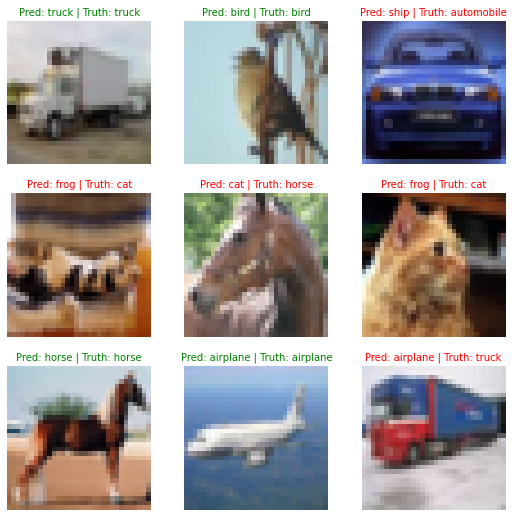

In [20]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)
  npimg = sample.numpy()
  npimg = np.transpose(npimg,(1,2,0))
  # Plot the target image
  plt.imshow(npimg, cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

## Making a confusion matrix for further prediction evaluation


In [21]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
net.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = net(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

1. Make a confusion matrix using `torchmetrics.ConfusionMatrix.`
2. Plot the confusion matrix using `seaborn`, `mlxtend.plotting.plot_confusion_matrix().` or `plotly`

In [34]:
!pip install mlxtend -U > /dev/null
!pip install torchmetrics > /dev/null

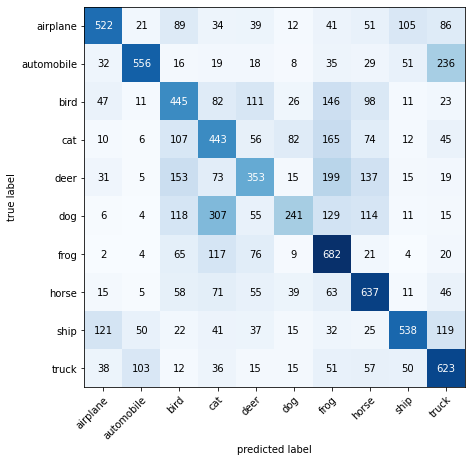

In [23]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.tensor(test_data.targets))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [32]:
len(class_names)

10

In [33]:
import plotly.express as px

fig = px.imshow(confmat_tensor,text_auto=True,x=class_names,y=class_names)
fig.show()